# Twitter Sentiment Analysis
### Author: Rachel Fein

## Overview
A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem
Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- What are the business's pain points related to this project?
- How did you pick the data analysis question(s) that you did?
- Why are these questions important from a business perspective?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
#import everything we will need for the analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV

import warnings 
warnings.filterwarnings('always')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


from nltk import word_tokenize
import nltk
from nltk import TweetTokenizer
tokenizer = TweetTokenizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachelfein/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# first look at the dataframe

data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'latin-1')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
# take a look at the dataframe basics

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# change column to product because it make more sense

data.rename(columns={"emotion_in_tweet_is_directed_at": "product",
                     "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [5]:
# see what products are getting tweeted at the most, not relevant to the business problem but still
# good to take a quick look into

def view_percentage(data):
    products = data.value_counts()
    return pd.DataFrame({'Count of Tweets':products,
                  '% of Tweets':products/len(data)*100}).round(2)
view_percentage(data['product'])

,Count of Tweets,% of Tweets
iPad,946,10.40
Apple,661,7.27
iPad or iPhone App,470,5.17
Google,430,4.73
iPhone,297,3.27
Other Google product or service,293,3.22
Android App,81,0.89
Android,78,0.86
Other Apple product or service,35,0.38


In [6]:
# take a closer look at the target variable: emotions & see what the tweets are mostly

view_percentage(data['emotion'])

,Count of Tweets,% of Tweets
No emotion toward brand or product,5389,59.27
Positive emotion,2978,32.75
Negative emotion,570,6.27
I can't tell,156,1.72


In [7]:
# Since "I cant tell" group as it is, is not helpful for the business problem 
# I choose to combine it with the no emotion group since they are the most similar

data['emotion'].replace("I can't tell", "No emotion toward brand or product", inplace=True)
data['emotion'].value_counts()

No emotion toward brand or product    5545
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [8]:
# majority are tweets without product indicated are neutral emotion
# this suggests that the tweet is general coversation and not so much geared towards a company

product_missing = data[data['product'].isnull()]
product_missing['emotion'].value_counts()

No emotion toward brand or product    5445
Positive emotion                       306
Negative emotion                        51
Name: emotion, dtype: int64

By far the majority of NaN data in the `product` column are assigned to `No emotion toward brand or product` category, that missing data is fine to keep in our dataframe as the business problem is to find the emotion of the tweets, and so the `product` column will not be used in our model. As long as the tweet is geared to either brand or tech in general those are potential buyers.

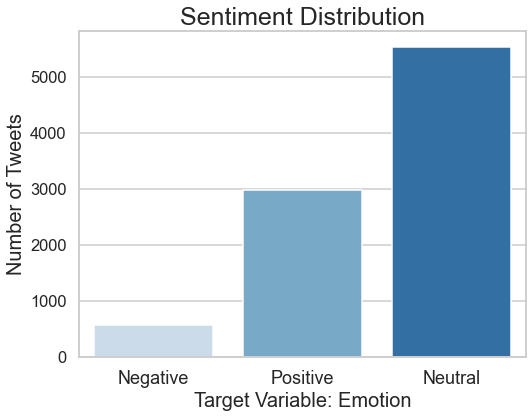

In [9]:
# take a better look at our model's target 

labels = ['Negative','Positive', 'Neutral']
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(x= data['emotion'], palette='Blues')
plt.title('Sentiment Distribution', fontsize=25)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('Target Variable: Emotion',fontsize=20)
plt.ylabel('Number of Tweets',fontsize=20)
plt.show()

#### At first glance we notice:
- The majority of the tweets have no emotion followed by positive emotion. The count of negative emotion tweets is far behind them both. The data is imbalanced and this will effect the model if not delt with properly.
- Tweets that fall under the `I can't tell` sediment are not helpful in answering the the business question. I combined that group with the No Emotions group since, they are the most similar & relateable.
- There is a large amount of data missing for the `product` column, this is fine since that information will not be used in our model nor is it relevant to the business problem.


## Data Preparation
- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

- Removing the duplicate tweets will help improve the accurancy of the model by removing some noise in the data that could distract the model
Code for data cleaning

In [10]:
# look for blank tweets to remove

data['tweet_text'].isna().sum()

1

In [11]:
# look at blank tweets to make sure it is safe to remove

data[data['tweet_text'].isnull()]

,tweet_text,product,emotion
6,NaN,NaN,No emotion toward brand or product


In [12]:
# drop missing tweet and reset the axis

data.drop(6, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [13]:
# double check the blank tweet is gone

print(data.isna().sum())

tweet_text       0
product       5801
emotion          0
dtype: int64


In [14]:
# look at shape of dataframe

data.shape

(9092, 3)

In [15]:
# filtering for dupes

dupes = data[data['tweet_text'].duplicated()]
len(dupes)

27

In [16]:
# drop the duplicate tweets

data.drop_duplicates(subset='tweet_text',inplace=True)
data.reset_index(drop=True, inplace=True)

In [17]:
# We see that we have removed the dupes

data.shape

(9065, 3)

#### Time to split the data to test & training sets
Before we start to clean the tweets we split the data into two groups: testing set & training set. This is done before tweet cleaning to avoid data leakage. Each cleaning step is performed on the test & training sets seperately going forward.

In [18]:
# we need to map the target since everything will need to be an int. when modeling

def map_target(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'Negative emotion':
        return 1
    else:
        return 0

In [19]:
# take a look to make sure everything looks as expected 

data['target'] = data['emotion'].apply(map_target)
data['target'].value_counts(dropna=False,normalize=True)

0    0.609818
2    0.327413
1    0.062769
Name: target, dtype: float64

In [20]:
# split the data at start to aviod data leakage. 

target = 'target'

y = data[target]
X = data.drop(target, axis=1)

#Stratify=y should help a little with the imbalance of the data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [21]:
# Look at ther % of each sediment in the two sets to see how equally divided the data is 

print("Train percent vaccinated:", y_train.value_counts(normalize=True))
print('-------------')
print("Test percent vaccinated: ", y_test.value_counts(normalize=True))

Train percent vaccinated: 0    0.609738
2    0.327449
1    0.062813
Name: target, dtype: float64
-------------
Test percent vaccinated:  0    0.610057
2    0.327305
1    0.062638
Name: target, dtype: float64


In [22]:
# this is to igore note filterwarning that tells me I am working on a copy of my dataset
pd.options.mode.chained_assignment = None

In [23]:
# make all letters lower case
X_train["tweet_text"] = X_train["tweet_text"].str.lower()
X_test["tweet_text"] = X_test["tweet_text"].str.lower()
X_train.head()

,tweet_text,product,emotion
2772,had no idea that @mention quietly launched its...,NaN,No emotion toward brand or product
9042,you know you've made it to #sxsw when you see ...,iPad,Positive emotion
123,christian #ipad #iphone devs i want to talk to...,iPad or iPhone App,Positive emotion
4646,apple opening a store in downtown atx for this...,Apple,Positive emotion
313,slate see as much traffic to mobile safari as ...,NaN,No emotion toward brand or product


In [24]:
# tokenize the tweets using TweetTokenizer. This separates the text into a list of words.
tokenizer = TweetTokenizer()

#applying TweetTokenize to both training and test sets
X_train["tweet_text"]=X_train["tweet_text"].apply(tokenizer.tokenize)
X_test["tweet_text"]=X_test["tweet_text"].apply(tokenizer.tokenize)
X_train.head()

,tweet_text,product,emotion
2772,"[had, no, idea, that, @mention, quietly, launc...",NaN,No emotion toward brand or product
9042,"[you, know, you've, made, it, to, #sxsw, when,...",iPad,Positive emotion
123,"[christian, #ipad, #iphone, devs, i, want, to,...",iPad or iPhone App,Positive emotion
4646,"[apple, opening, a, store, in, downtown, atx, ...",Apple,Positive emotion
313,"[slate, see, as, much, traffic, to, mobile, sa...",NaN,No emotion toward brand or product


In [25]:
# add the generic stopwords & punctuation we want to be removed from the tweets
stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)

additional_punc = ['...']
stopwords_list.extend(additional_punc)

#remove stopwords from both training and test set
X_train["tweet_text"] = X_train["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])
X_test["tweet_text"] = X_test["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])
X_train.head()

,tweet_text,product,emotion
2772,"[idea, @mention, quietly, launched, hotpot, re...",NaN,No emotion toward brand or product
9042,"[know, made, #sxsw, see, bunch, grown, men, ho...",iPad,Positive emotion
123,"[christian, #ipad, #iphone, devs, want, talk, ...",iPad or iPhone App,Positive emotion
4646,"[apple, opening, store, downtown, atx, wknd, ....",Apple,Positive emotion
313,"[slate, see, much, traffic, mobile, safari, ap...",NaN,No emotion toward brand or product


In [26]:
stopwords_list[-10:]

['\\', ']', '^', '_', '`', '{', '|', '}', '~', '...']

In [27]:
stopwords_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [28]:
# prep to remove words with less than two characters, short words add distracting noise
shortword = re.compile(r'\W*\b\w{1,3}\b')
delete = re.compile("''")
#delete2 = re.compile("']")


def cleaner(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'rt[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', str(tweet)) # remove hyperlink in tweet
    tweet = re.sub(r',', '', str(tweet)) # remove commas 
    tweet = shortword.sub('', str(tweet)) # remove short words 
    tweet = delete.sub(' ', str(tweet)) # remove short words 
    #tweet = delete2.sub(' ', str(tweet)) # remove short words
    #tweet = delete3.sub(' ', str(tweet)) # remove short words
    #tweet = re.sub(r'[', '', str(tweet)) # removes hashtag
    #tweet = re.sub(r"']", '', str(tweet)) # removes hashtag
    #tweet = re.sub(r'[^\w\s]', '', str(tweet)) # removes punctuations
    
    return tweet

# apply cleaner funtion to train set
X_train["tweet_text"] = X_train["tweet_text"].apply(cleaner)

In [29]:
# apply cleaner funtion to test set
X_test["tweet_text"] = X_test["tweet_text"].apply(cleaner)

In [30]:
# double check tweets look as expected
X_train.head(8)

,tweet_text,product,emotion
2772,['idea' 'quietly' 'launched' 'hotpot' 'revie...,NaN,No emotion toward brand or product
9042,['know' 'made' 'sxsw' 'bunch' 'grown' 'hooting...,iPad,Positive emotion
123,['christian' 'ipad' 'iphone' 'devs' 'want' 'ta...,iPad or iPhone App,Positive emotion
4646,['apple' 'opening' 'store' 'downtown' 'wknd' '...,Apple,Positive emotion
313,['slate' 'much' 'traffic' 'mobile' 'safari' 'i...,NaN,No emotion toward brand or product
2577,"['anybody' 'sxsw' 'mobile' 'apps' 'work"" 'down...",iPad or iPhone App,Negative emotion
650,['practical' 'ideas' 'android' 'development/an...,NaN,No emotion toward brand or product
8270,['guess' 'crowd' 'lined' 'ipad' 'mashhash' 'pa...,NaN,No emotion toward brand or product


In [31]:
#delete = re.compile("''")
#X_train['tweet_text'] = [delete.sub('', tweet) for tweet in X_train['tweet_text']]
#X_test['tweet_text'] = [delete.sub('', tweet) for tweet in X_test['tweet_text']]

In [32]:
X_train.head(10)

,tweet_text,product,emotion
2772,['idea' 'quietly' 'launched' 'hotpot' 'revie...,NaN,No emotion toward brand or product
9042,['know' 'made' 'sxsw' 'bunch' 'grown' 'hooting...,iPad,Positive emotion
123,['christian' 'ipad' 'iphone' 'devs' 'want' 'ta...,iPad or iPhone App,Positive emotion
4646,['apple' 'opening' 'store' 'downtown' 'wknd' '...,Apple,Positive emotion
313,['slate' 'much' 'traffic' 'mobile' 'safari' 'i...,NaN,No emotion toward brand or product
2577,"['anybody' 'sxsw' 'mobile' 'apps' 'work"" 'down...",iPad or iPhone App,Negative emotion
650,['practical' 'ideas' 'android' 'development/an...,NaN,No emotion toward brand or product
8270,['guess' 'crowd' 'lined' 'ipad' 'mashhash' 'pa...,NaN,No emotion toward brand or product
2759,['pdparticle' 'said' 'able' 'ipad' 'sxsw' 'a...,NaN,No emotion toward brand or product
4402,['ireport' 'austin' 'apple' 'store' 'highlig...,NaN,No emotion toward brand or product


In [33]:
X_test.head(10)

,tweet_text,product,emotion
5978,' 'austin' 'know' 'little' 'iphone' 'android' ...,NaN,No emotion toward brand or product
4536,['anyone' 'know' 'store' 'sxsw' 'still' 'ipa...,iPad,Positive emotion
3892,['exhibit' 'hall' 'open' 'sxsw' 'visit' 'chanc...,iPad,Positive emotion
5320,' 'want' 'micro' 'charger' 'samsung' 'androi...,NaN,No emotion toward brand or product
6530,' 'google' 'launch' 'major' 'social' 'networ...,NaN,No emotion toward brand or product
3601,""" 'chance' 'watch' 'people' 'actually' 'using'...",iPad,Positive emotion
6789,' 'toptweets' 'rumor' 'apple' 'opening' 't...,NaN,No emotion toward brand or product
5096,"' 'becoming' 'competitors' ""they"" 'sta...",NaN,No emotion toward brand or product
8389,[ 'sxsw' 'folks' 'pretty' 'kool-drinking' 'bu...,NaN,No emotion toward brand or product
4680,"[""that"" 'funny' 'think' 'everywhere' 'look' ...",NaN,No emotion toward brand or product


In [34]:
# we use a lemmatizer, this reduces words to their simplest form. This helps reduce some distracting noise
wordnet_tokenizer = WordNetLemmatizer()
X_train["tweet_text"] = X_train["tweet_text"].apply(wordnet_tokenizer.lemmatize)
X_test["tweet_text"] = X_test["tweet_text"].apply(wordnet_tokenizer.lemmatize)

In [35]:
X_test['tweet_text'][:5]

5978    ' 'austin' 'know' 'little' 'iphone' 'android' ...
4536    ['anyone' 'know'   'store' 'sxsw' 'still' 'ipa...
3892    ['exhibit' 'hall' 'open' 'sxsw' 'visit' 'chanc...
5320    '   'want' 'micro' 'charger' 'samsung' 'androi...
6530    '   'google' 'launch' 'major' 'social' 'networ...
Name: tweet_text, dtype: object

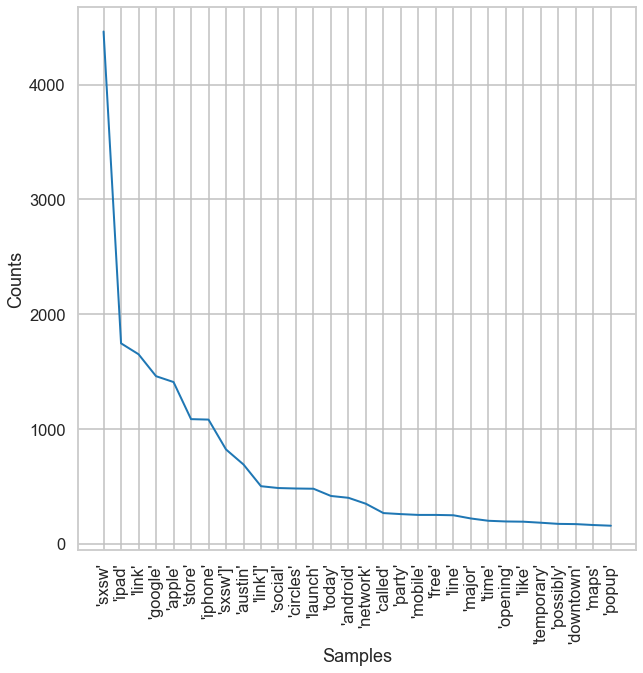

In [36]:
#freq_dis = nltk.FreqDist(X_train['tweet_text']) #number of occurances of each word
sentiment_words = ''.join([word for word in X_train['tweet_text']]) #words from the tweets that are positive
list_words = [ x for x in sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [37]:
#building a wordcloud on the data from all tweets
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='tab20b').generate(sentiment_words)
#plt.figure(figsize=(10, 7))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()

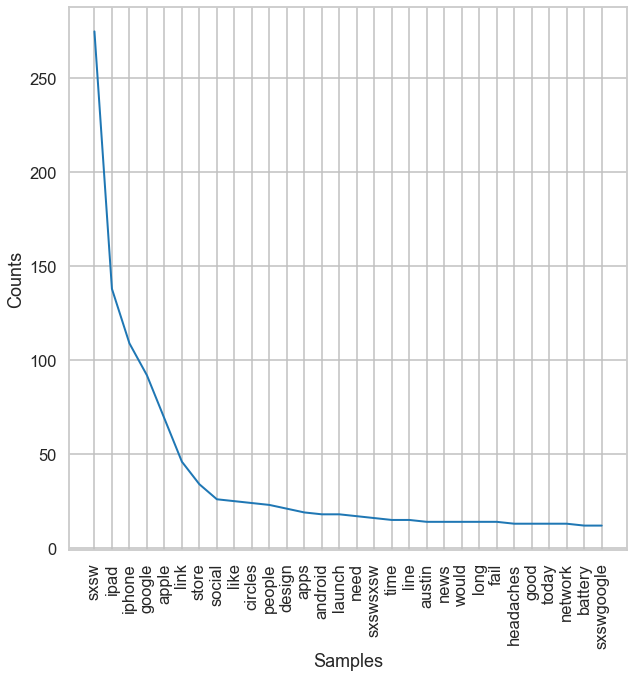

In [38]:
# lets see some of the most common words in negative tweets

neg = X_train[X_train["emotion"] == 'Negative emotion']
neg_sentiment_words = ''.join([word for word in neg['tweet_text']]) ##words from the tweets that are negative
neg_list_words = [ x for x in neg_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(neg_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

/Users/rachelfein/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/rachelfein/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


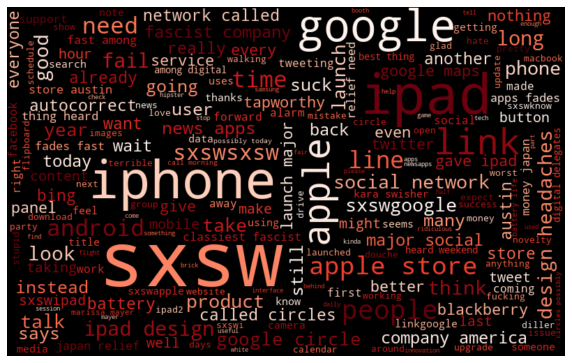

In [40]:
#building a wordcloud on the data from all tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Reds').generate(neg_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# lets see some of the most common words in negative tweets

pos = X_train[X_train["emotion"] == 'Positive emotion']
pos_sentiment_words = ''.join([word for word in pos['tweet_text']]) ##words from the tweets that are negative
pos_list_words = [ x for x in pos_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(pos_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

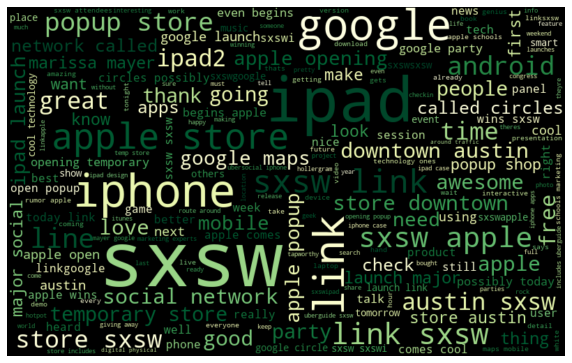

In [67]:
#building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='YlGn').generate(pos_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

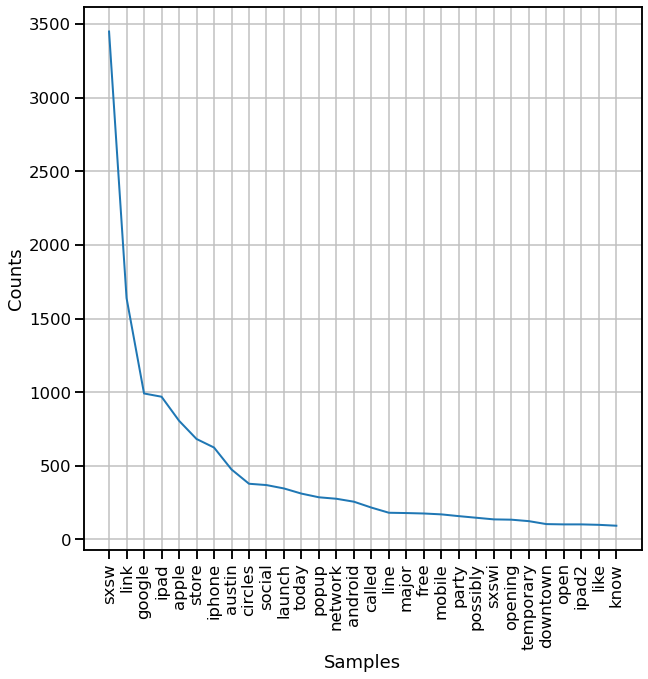

In [50]:
# lets see some of the most common words in negative tweets

nuetral = X_train[X_train["emotion"] == 'No emotion toward brand or product']
nuetral_sentiment_words = ''.join([word for word in nuetral['tweet_text']]) ##words from the tweets that are negative
nuetral_list_words = [ x for x in nuetral_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(nuetral_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

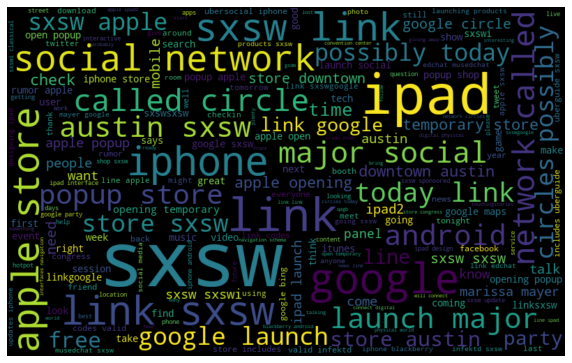

In [51]:
#building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(nuetral_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Interesting that sxsw and austin come up in both positive and negative tweets. After a google search I found out that SXSW is a annual festival in Austin, Texas.

## Data Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze or model the data?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

In [33]:
# Import 


# Instantiate a vectorizer using TF-IDF. A max_df =.90 means that words in over 90% tweets are not used
tfidf = TfidfVectorizer(min_df = 2, max_df=.90)

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf = tfidf.fit_transform(X_train['tweet_text'])


# Fit the vectorizer on X_train["text"] and transform it
X_test_tfidf = tfidf.transform(X_test['tweet_text']) 


# Visually inspect the vectorized train data
pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns=tfidf.get_feature_names())

,0011,0311,0312,0313,0314,0315,1000,100s,1030,1100,...,zynga,û_time,ûªll,ûªre,ûïbest,ûïcheckin,ûïcoming,ûïthe,ûïwin,ûòand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
y_hat_test = model.predict(X_test_tfidf)

In [48]:
# we know that the data is not balenced so we will need to deal with that first
from sklearn.metrics import plot_confusion_matrix

# make function to view model performance 
from sklearn import metrics
def model_eval(model, X_test_tfidf, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    # Get Predictions
    y_hat_train = model.predict(X_train_tfidf)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_tfidf)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))
    
    print("---------------------------------------")
    
    print(f'f1 train set: {metrics.f1_score(y_train,y_hat_train, average="weighted")}')
    print(f'f1 test set: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
    
    print("---------------------------------------")

    print('Confusion matrix for test set:')
    plot_confusion_matrix(model,X_test_tfidf,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.95      0.98      0.96      4158
   Postitive       0.97      0.92      0.94       427
    Negative       0.97      0.91      0.94      2234

    accuracy                           0.95      6819
   macro avg       0.96      0.94      0.95      6819
weighted avg       0.95      0.95      0.95      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.70      0.88      0.78      1386
   Postitive       0.58      0.21      0.31       143
    Negative       0.66      0.42      0.52       744

    accuracy                           0.69      2273
   macro avg       0.65      0.51      0.54      2273
weighted avg       0.68      0.69      0.66      2273

---------------------------------------
f1 train set: 0.9526117424680263
f1 test set: 0.664516684558599
---------------------------------------
Confusion matrix 

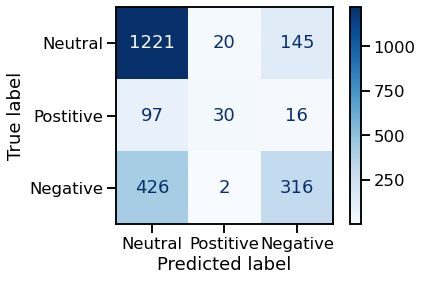

In [49]:
# set the fuction to the tree baseline model
rf_base = RandomForestClassifier()
model = rf_base.fit(X_train_tfidf,y_train)

model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [45]:
y_hat_test = model.predict(X_test_tfidf)
y_hat_train = model.predict(X_train_tfidf)
print(f'f1: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
print(f'f1: {metrics.f1_score(y_train,y_hat_train, average="weighted")}')

f1: 0.664951317686787
f1: 0.9526424005206903


In [39]:
from imblearn.over_sampling import SMOTE

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_tfidf, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 



2    4158
1    4158
0    4158
Name: target, dtype: int64


In [40]:
# we know that the data is not balanced so we will need to deal with that first

# make function to view model performance 
from sklearn import metrics
def model_eval_smote(model, X_test_tfidf, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    # Get Predictions
    y_hat_train = model.predict(X_train_resampled)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train_resampled, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_tfidf)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))

    
    print("-------------")
    
        # Scores 
    print(dashes)
    print("MODEL EVALUATION")
    print(dashes)
    
    
    plot_confusion_matrix(model,X_test_tfidf,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.95      0.97      0.96      4158
   Postitive       0.99      1.00      0.99      4158
    Negative       0.97      0.95      0.96      4158

    accuracy                           0.97     12474
   macro avg       0.97      0.97      0.97     12474
weighted avg       0.97      0.97      0.97     12474

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.71      0.83      0.76      1386
   Postitive       0.45      0.24      0.32       143
    Negative       0.61      0.47      0.53       744

    accuracy                           0.67      2273
   macro avg       0.59      0.51      0.54      2273
weighted avg       0.66      0.67      0.66      2273

-------------


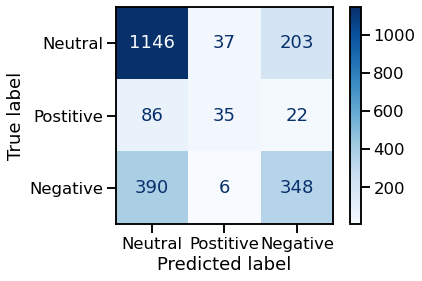

In [41]:
model = RandomForestClassifier()

model.fit(X_train_resampled, y_train_resampled)

model_eval_smote(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

SMOTE made the model worse, so we will stick with the orginal distributed data.

In [86]:
model = rf_base.fit(X_train_tfidf,y_train)

param = {'criterion': ['gini', 'entropy'],
         'n_estimators':[200, 250],
         'min_samples_split': [8, 10, 15],
         'min_samples_leaf': [2, 3, 4]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv= 5, scoring=f1)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 250}

In [88]:
param = {'criterion': ['gini'],
         'n_estimators':[250, 280],
         'min_samples_split': [6,8],
         'min_samples_leaf': [2]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv=5, scoring=f1)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 250}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.80      0.97      0.88      4158
   Postitive       0.96      0.29      0.45       427
    Negative       0.90      0.66      0.76      2234

    accuracy                           0.83      6819
   macro avg       0.89      0.64      0.70      6819
weighted avg       0.84      0.83      0.81      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.69      0.92      0.79      1386
   Postitive       0.77      0.12      0.21       143
    Negative       0.69      0.37      0.48       744

    accuracy                           0.69      2273
   macro avg       0.72      0.47      0.49      2273
weighted avg       0.69      0.69      0.65      2273

-------------


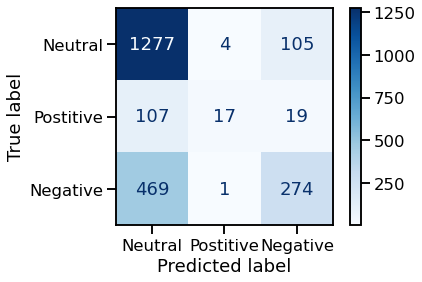

In [89]:
params = gridsearch.best_params_
model = RandomForestClassifier(**params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

RandomForest isnt producing a good model, lets try a logistic Regression model & see if that will improve the results

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.94      0.96      0.95      4158
   Postitive       0.95      0.94      0.94       427
    Negative       0.92      0.90      0.91      2234

    accuracy                           0.94      6819
   macro avg       0.94      0.93      0.93      6819
weighted avg       0.94      0.94      0.94      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.72      0.68      0.70      1386
   Postitive       0.26      0.37      0.30       143
    Negative       0.52      0.53      0.52       744

    accuracy                           0.61      2273
   macro avg       0.50      0.53      0.51      2273
weighted avg       0.63      0.61      0.62      2273

-------------


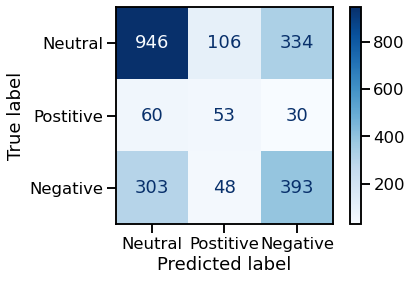

In [90]:
# Import functions needed
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Set a C value, this tells the model how to choose the parameters & how much 
# weight to but on the training data a low C will be a more complex model but risks over fitting 
model = LogisticRegression(max_iter=5000, C=1e12)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [57]:
y_hat_test = model.predict(X_test_tfidf)
print(f'f1: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')

f1: 0.6148674222991377


In [ ]:
model = LogisticRegression(max_iter=5000)

param = {'penalty': ['l2', 'l1'],
         'solver': ['liblinear', 'saga']}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv=5)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.78      0.95      0.86      4158
   Postitive       0.93      0.19      0.32       427
    Negative       0.84      0.63      0.72      2234

    accuracy                           0.80      6819
   macro avg       0.85      0.59      0.63      6819
weighted avg       0.81      0.80      0.78      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.70      0.88      0.78      1386
   Postitive       0.71      0.08      0.15       143
    Negative       0.63      0.45      0.52       744

    accuracy                           0.69      2273
   macro avg       0.68      0.47      0.48      2273
weighted avg       0.68      0.69      0.66      2273

-------------


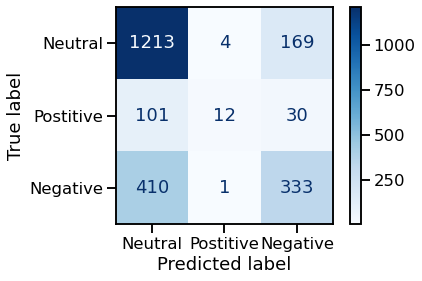

In [47]:
params = gridsearch.best_params_
model = LogisticRegression(max_iter=5000, **params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [82]:
model = MultinomialNB()
param = {'alpha':[0,1]}

gridsearch = GridSearchCV(model,
                          param_grid=param, cv= 5, scoring=f1)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_


{'alpha': 0}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.83      0.92      0.87      4158
   Postitive       0.82      0.67      0.74       427
    Negative       0.83      0.70      0.76      2234

    accuracy                           0.83      6819
   macro avg       0.83      0.76      0.79      6819
weighted avg       0.83      0.83      0.83      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.71      0.82      0.76      1386
   Postitive       0.50      0.22      0.31       143
    Negative       0.58      0.47      0.52       744

    accuracy                           0.67      2273
   macro avg       0.60      0.50      0.53      2273
weighted avg       0.65      0.67      0.65      2273

-------------


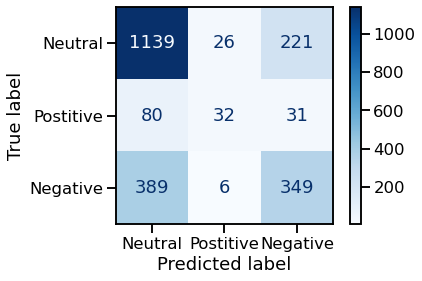

In [83]:
params = gridsearch.best_params_
model = MultinomialNB(**params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.74      0.97      0.84      4158
   Postitive       0.95      0.10      0.17       427
    Negative       0.84      0.50      0.63      2234

    accuracy                           0.76      6819
   macro avg       0.84      0.52      0.55      6819
weighted avg       0.79      0.76      0.73      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.67      0.92      0.77      1386
   Postitive       0.89      0.06      0.11       143
    Negative       0.63      0.30      0.41       744

    accuracy                           0.66      2273
   macro avg       0.73      0.43      0.43      2273
weighted avg       0.67      0.66      0.61      2273

-------------


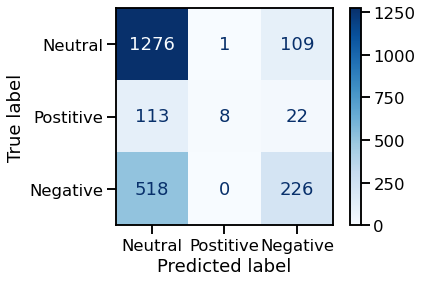

In [70]:
params = gridsearch.best_params_
model = RandomForestClassifier(**params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);



clf = MultinomialNB()
# use a full grid over all parameters
param_grid = {'alpha':[0,1] }
f1 = make_scorer(f1_score , average='weighted')
# run grid search
grid = GridSearchCV(clf, cv=5,scoring=f1, param_grid=param_grid)
grid.fit(X_train_tfidf,y_train)
print("Grid-Search with roc_auc")
print("Best parameters:", grid.best_params_)



model = MultinomialNB()
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [67]:


#clf = MultinomialNB()
# use a full grid over all parameters
#param_grid = {'alpha':[0,1] }
#f1 = make_scorer(f1_score , average='weighted')
# run grid search
#grid = GridSearchCV(clf, cv=5,scoring=f1, param_grid=param_grid)
#grid.fit(X_train_tfidf,y_train)
#print("Grid-Search with roc_auc")
#print("Best parameters:", grid.best_params_)
#print("Best cross-validation score (f1)): {:.3f}".format(grid.best_score_))
#y_predict = grid.predict(X_test_tfidf)
#rint('The weighted F1 score with the best hyperparameters is ', end = '')
#print(f1_score(y_test, y_predict, average='weighted'))
#print ("Classification Report: ")
#print (classification_report(y_test, y_predict))

Grid-Search with roc_auc
Best parameters: {'alpha': 0}
Best cross-validation score (f1)): 0.645
The weighted F1 score with the best hyperparameters is 0.6532614284095963
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1386
           1       0.50      0.22      0.31       143
           2       0.58      0.47      0.52       744

    accuracy                           0.67      2273
   macro avg       0.60      0.50      0.53      2273
weighted avg       0.65      0.67      0.65      2273



## Evaluation
Evaluate how well your work solves the stated business problem.

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model?
- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

## Conclusion

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project?

Business problem
Who to send promoted ads to only nuetral or positive tweets to ecurage people to upgrade their devices. With a promated tweet costing $0.50 t0 $2 an action, your team has already decided that you want to put your marketing cost towards people who have been detected to already have an intrest in Google or Apple products. We have choosen to eliminate those who already have a negative view of the brands as a promoted ad to them would be a waist of your crucial marketing budget. 